# Churn Project
  --------------------------------------------------------------------

_note_: This notebook was adapted from a number external sources:
* **[Churn Prediction and Prevention in Python](https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5)**
* **[Telecom Customer Churn Prediction](https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction*)**

#### **notebook how-to's**
* Create and test a custom `data_clean` function 
* Examine data using a serverless (containerized) `describe` function
* Train a number of machine learning algorithms
* Tune hyperparameters 
* Create an automated ML pipeline from various library functions
* Run and track the pipeline results and artifacts

## a custom data cleaning function


In [1]:
# nuclio: ignore
import nuclio

In [2]:
import os

import json
import pandas as pd
import numpy as np
from collections import defaultdict

from cloudpickle import dumps, dump, load

from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

def data_clean(
    context:MLClientCtx, 
    src: DataItem,
    file_ext: str = "csv",
    models_dest: str = "models/encoders",
    cleaned_key: str = "cleaned-data",
    encoded_key: str = "encoded-data"
):
    """process a raw churn data file
    
    Data has 3 states here: `raw`, `cleaned` and `encoded`
    
    * `raw` kept by default, the pipeline begins with a raw data artifact
    * `cleaned` kept for charts, presentations
    * `encoded` is input for a cross validation and training function
    
    steps (not necessarily in correct order, some parallel)
    * column name maps
    * deal with nans and other types of missings/junk
    * label encode binary and ordinal category columns
    * create category ranges from numerical columns
    And finally,
    * test
    
    Why we don't one-hot-encode here? One hot encoding isn't a necessary
    step for all algorithms. It can also generate a very large feature
    matrix that doesn't need to be serialized (even if sparse).
    So we leave one-hot-encoding for the training step.
    
    What about scaling numerical columns? Same as why we don't one hot
    encode here. Do we scale before train-test split?  IMHO, no.  Scaling
    before splitting introduces a type of data leakage.  In addition,
    many estimators are completely immune to the monotonic transformations
    implied by scaling, so why waste the cycles?
    
    TODO: 
        * parallelize where possible
        * more abstraction (more parameters, chain sklearn transformers)
        * convert to marketplace function
        
    :param context:          the function execution context
    :param src:              an artifact or file path
    :param file_ext:         file type for artifacts
    :param models_dest:       label encoders and other preprocessing steps
                             should be saved together with other pipeline
                             models
    :param cleaned_key:      key of cleaned data table in artifact store
    :param encoded_key:      key of encoded data table in artifact store
    """
    df = src.as_df()
    
    # drop columns
    drop_cols_list = ["customerID", "TotalCharges"]
    df.drop(drop_cols_list, axis=1, inplace=True)
    
    # header transformations
    old_cols = df.columns
    rename_cols_map = {
        "SeniorCitizen" : "senior",
        "Partner"       : "partner",
        "Dependents"    : "deps",
        "Churn"         : "labels"
    }
    df.rename(rename_cols_map, axis=1, inplace=True)

    # add drop column to logs:
    for col in drop_cols_list:
        rename_cols_map.update({col: "_DROPPED_"})
    
    # log the op
    tp = os.path.join(models_dest, "preproc-column_map.json")
    context.log_artifact("preproc-column_map.json",
                         body=json.dumps(rename_cols_map),
                         local_path=tp)
    
    # VALUE transformations

    # clean
    # truncate reply to "No"
    df = df.applymap(lambda x: "No" if str(x).startswith("No ") else x)

    # encode numerical type as category bins (ordinal)
    bins = [0, 12, 24, 36, 48, 60, np.inf]
    labels = [0, 1, 2, 3, 4, 5]
    tenure = df.tenure.copy(deep=True)
    df["tenure_map"] = pd.cut(df.tenure, bins, labels=False)
    tenure_map = dict(zip(bins, labels))
    # save this transformation
    tp = os.path.join(models_dest, "preproc-numcat_map.json")
    context.log_artifact("preproc-numcat_map.json", 
                         body=bytes(json.dumps(tenure_map).encode("utf-8")), 
                         local_path=tp)
    
    context.log_dataset(cleaned_key, df=df, format=file_ext, index=False)
    
    # label encoding - generate model for each column saved in dict
    # some of these columns may be hot encoded in the training step
    fix_cols = ["gender", "partner", "deps", "OnlineSecurity", 
                "OnlineBackup", "DeviceProtection", "TechSupport",
                "StreamingTV", "StreamingMovies", "PhoneService",
                "MultipleLines", "PaperlessBilling", "InternetService", 
                "Contract", "PaymentMethod", "labels"]
    
    d = defaultdict(LabelEncoder)
    df[fix_cols] = df[fix_cols].apply(lambda x: d[x.name].fit_transform(x.astype(str)))
    context.log_dataset(encoded_key, df=df, format=file_ext, index=False)

    model_bin = dumps(d)
    context.log_model("model", 
                      body=model_bin,
                      artifact_path=os.path.join(context.artifact_path, 
                                                 models_dest),
                      model_file="model.pkl")
    # would be nice to have a check here on the integrity of all done
    # raw->clean->encoded->clean->raw

In [3]:
# nuclio: end-code

## Create a project to host our functions, jobs and artifacts

Projects are used to package multiple functions, workflows, and artifacts. We usually store project code and definitions in a Git archive.

The following code creates a new project in a local dir and initialize git tracking on that

In [4]:
import mlrun

project_name_base = "churn-project"
project_dir = "./project"
project_name, artifact_path = mlrun.set_environment('http://mlrun-api:8080', artifact_path='./data', project=project_name_base, user_project=True)
churn_proj = mlrun.new_project(project_name, project_dir, init_git=True)

> 2021-10-27 05:52:13,641 [info] created and saved project churn-project-dani


### register an input artifact/dataset in the store 
Log the raw data file as an artifact, enabeling us to refer to it by name (`store:///raw-data`) and ensuring we keep a record of the source data used

In [5]:
# Set the source URL prefix
url_prefix = os.environ.get('SAMPLE_DATA_SOURCE_URL_PREFIX', 'https://s3.wasabisys.com/iguazio/')

In [6]:
# Set the source-data URL
source_url = f'{url_prefix.rstrip("/")}/data/demos-data/customer-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [7]:
churn_proj.log_artifact("raw-data", target_path=source_url)

<a id="test-locally"></a>
### Run the data generator function locally

The functions above can be tested locally. Parameters, inputs, and outputs can be specified in the API or the `Task` object.<br>
when using `run_local()` the function inputs and outputs are automatically recorded by MLRun experiment and data tracking DB.

In each run we can specify the function, inputs, parameters/hyper-parameters, etc... For more details, see the [mlrun_basics notebook](mlrun_basics.ipynb).

In [8]:
# run the function locally
cleaner = mlrun.run_local(
    name="data_clean",
    handler=data_clean, 
    inputs={"src": "store:///raw-data"},
    params={"file_ext" : "csv",
            "apply_tenure_map": False})

> 2021-10-27 05:52:13,957 [info] starting run data_clean uid=dbfbd479dafb42f7af087fa42d142c2f DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
churn-project-dani,...2d142c2f,0,Oct 27 05:52:14,completed,data_clean,v3io_user=danikind=handlerowner=danihost=jupyter-dani-5fcb874cdc-mq7f8,src,file_ext=csvapply_tenure_map=False,,preproc-column_map.jsonpreproc-numcat_map.jsoncleaned-dataencoded-datamodel


> 2021-10-27 05:52:15,539 [info] run executed, status=completed


## Create a Fully Automated ML Pipeline

Are we using GPU's?

In [9]:
GPUS = False

#### Convert our local code to a distributed serverless function object 

In [10]:
clean_data_fn_params = {
    "name"        : "clean_data",
    "kind"        : "job",
    "image"       : "mlrun/ml-models-gpu" if GPUS else "mlrun/ml-models",
    "description" : "clean and encode raw data",
    "categories"  : ["data-prep"],
    "labels"      : {"author": "yasha", "framework": "xgboost"}      
}

clean_func = mlrun.code_to_function(**clean_data_fn_params)
churn_proj.set_function(clean_func)

#### Add more functions to our project to be used in our pipeline (from the functions hub/marketplace)

AutoML training (classifier), Model validation (test_classifier), Real-time model server, and Model REST API Tester

In [11]:
churn_proj.set_function("hub://describe", "describe")

churn_proj.set_function("hub://xgb_trainer", "classify")
churn_proj.set_function("hub://xgb_test", "xgbtest")

churn_proj.set_function("hub://coxph_trainer", "survive")
churn_proj.set_function("hub://coxph_test", "coxtest")

churn_proj.set_function("hub://churn_server", "server")

#### Define and save a pipeline 

The following workflow definition will be written into a file, it describes a Kubeflow execution graph (DAG)<br>
and how functions and data are connected  to form an end to end pipeline. 

Check the code below to see how functions objects are initialized and used (by name) inside the workflow.<br>
The `workflow.py` file has two parts, initialize the function objects and define pipeline dsl (connect the function inputs and outputs).

In [12]:
%%writefile project/workflow.py
from kfp import dsl
from mlrun import mount_v3io
import os

funcs = {}
GPUS = False

# init functions is used to configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(mount_v3io())
        
    functions["server"].set_env("INFERENCE_STREAM", f"{os.environ['V3IO_HOME']}/artifacts/customer-churn-prediction/model_stream")

    
@dsl.pipeline(
    name="Demo training pipeline",
    description="Shows how to use mlrun."
)
def kfpipeline():
    
    # encode the data
    clean = funcs["clean-data"].as_step(
        name="clean-data",
        handler="data_clean",
        params={"file_ext": "csv",
                "models_dest": "models/encoders"},
        inputs={"src": "store:///raw-data"},  # use an artifact from the feature store
        outputs=["cleaned-data",
                 "encoded-data"])

    # analyze our dataset
    describe = funcs["describe"].as_step(
        name="summary",
        params={"label_column"  : "labels"},
        inputs={"table": clean.outputs["encoded-data"]})
    
    # train with hyper-paremeters
    xgb = funcs["classify"].as_step(
        name="current-state",
        handler="train_model",
        params={"sample"                  : -1, 
                "label_column"            : "labels",
                "model_type"              : "classifier",
                # xgb class initializers (tuning candidates):
                "CLASS_tree_method"       : "gpu_hist" if GPUS else "hist",
                "CLASS_objective"         : "binary:logistic",
                "CLASS_n_estimators"      : 50,
                "CLASS_max_depth"         : 5,
                "CLASS_learning_rate"     : 0.15,
                "CLASS_colsample_bylevel" : 0.7,
                "CLASS_colsample_bytree"  : 0.8,
                "CLASS_gamma"             : 1.0,
                "CLASS_max_delta_step"    : 3,
                "CLASS_min_child_weight"  : 1.0,
                "CLASS_reg_lambda"        : 10.0,
                "CLASS_scale_pos_weight"  : 1,
                "FIT_verbose"             : 0,
                "CLASS_subsample"         : 0.9,
                "CLASS_booster"           : "gbtree",
                "CLASS_random_state"      : 1,
                # encoding:
                "encode_cols"        : {"InternetService": "ISP",
                                        "Contract"       : "Contract",
                                        "PaymentMethod"   : "Payment"},
                # outputs
                "models_dest"        : "models",
                "plots_dest"         : "plots",
                "file_ext"           : "csv"
               },
        inputs={"dataset"   : clean.outputs["encoded-data"]},
        outputs=["model", "test_set"])

    cox = funcs["survive"].as_step(
        name="survival-curves",
        params={"sample"                  : -1, 
                "event_column"            : "labels",
                "strata_cols" : ['InternetService', 'StreamingMovies', 
                                 'StreamingTV', 'PhoneService'],
                "encode_cols" : {"Contract"       : "Contract",
                                 "PaymentMethod"  : "Payment"},
                # outputs
                "models_dest"        : "models/cox",
                "plots_dest"         : "plots",
                "file_ext"           : "csv"
               },
        inputs={"dataset"   : clean.outputs["encoded-data"]},
        outputs=["cx-model", "tenured-test-set"])

    test_xgb = funcs["xgbtest"].as_step(
        name="test-classifier",
        params={"label_column": "labels",
                "plots_dest"  : "customer-churn-prediction/test/xgb"},
        inputs={"models_path" : xgb.outputs["model"],
                "test_set"    : xgb.outputs["test_set"]})

    test_cox = funcs["coxtest"].as_step(
        name="test-regressor",
        params={"label_column": "labels",
                "plots_dest"  : "customer-churn-prediction/test/cox"},
        inputs={"models_path" : cox.outputs["cx-model"],
                "test_set"    : cox.outputs["tenured-test-set"]})

    # deploy our model as a serverless function
    deploy_xgb = funcs["server"].deploy_step(
        models={"churn_server_v1": xgb.outputs["model"]})
    deploy_xgb.after(cox)

Writing project/workflow.py


In [13]:
# register the workflow file as "main"
churn_proj.set_workflow("main", "workflow.py", embed=True)

Save the project definitions to a file (project.yaml), it is recommended to commit all changes to a Git repo.

In [14]:
churn_proj.save()

In [15]:
# View project defition (YAML)
#print(churn_proj.to_yaml())

<a id="run-pipeline"></a>
## Run a pipeline workflow
use the `run` method to execute a workflow, you can provide alternative arguments and specify the default target for workflow artifacts.<br>
The workflow ID is returned and can be used to track the progress or you can use the hyperlinks

> Note: The same command can be issued through CLI commands:<br>
    `mlrun project my-proj/ -r main -p "v3io:///users/admin/mlrun/kfp/{{workflow.uid}}/"`

The dirty flag allow us to run a project with uncommited changes (when the notebook is in the same git dir it will always be dirty)

In this cell we will run the `main` workflow via `KubeFlow Pipelines` on top of our cluster.  
Running the pipeline may take some time. Due to possible jupyter timeout, it's best to track the pipeline's progress via KFP or the MLRun UI.

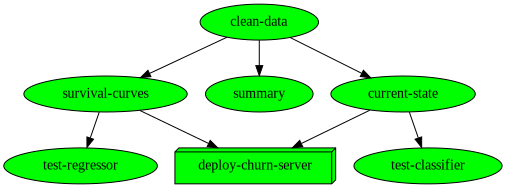

uid,start,state,name,results,artifacts
...1cf70e65,Oct 27 05:53:38,completed,test-classifier,accuracy=0.8014789533560864test-error=0.19852104664391354rocauc=0.857223083297907brier_score=0.13276025486204188f1-score=0.5918128654970761precision_score=0.655440414507772recall_score=0.5394456289978679,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binary
...bc4debbf,Oct 27 05:53:18,completed,test-regressor,,cox-test-summary
...15199f6f,Oct 27 05:52:51,completed,current-state,accuracy=0.8015170670037927test-error=0.19848293299620734rocauc=0.8396024703608749brier_score=0.13701816545805814f1-score=0.5905059989567031precision_score=0.6468571428571429recall_score=0.5431861804222649,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel
...032f3bac,Oct 27 05:52:51,completed,survival-curves,,tenured-test-setkm-timelineskm-survivalkm-modelcoxhazard-summarycx-model
...2a987cbe,Oct 27 05:52:51,completed,summary,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation
...a6427395,Oct 27 05:52:36,completed,clean-data,,preproc-column_map.jsonpreproc-numcat_map.jsoncleaned-dataencoded-datamodel


In [16]:
artifact_path = os.path.join(mlrun.mlconf.artifact_path, "pipeline/{{workflow.uid}}")
run_id = churn_proj.run(
    "main",
    arguments={},
    artifact_path=artifact_path,
    dirty=True, watch=True)

**[back to top](#top)**